In [1]:
# import CartPole.py from local directory
import CartPole, sf3utility
import matplotlib.collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate, scipy.stats.qmc, scipy.optimize
import random, copy

plt.rcParams["font.family"] = "Georgia"
#plt.rcParams['faigure.figsize'] = [9.0, 7.0]
#plt.rcParams['figure.dpi'] = 400

# store results for later
cache = {}

In [2]:
# allows nice plots that can be redrawn
%matplotlib notebook

<IPython.core.display.Javascript object>


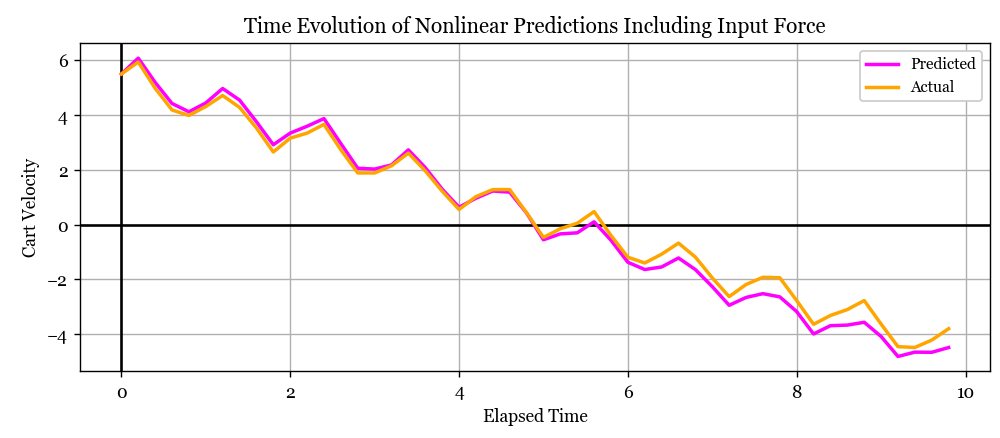

In [3]:
# import CartPole.py from local directory
import CartPole, sf3utility
import matplotlib.collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate, scipy.stats.qmc, scipy.optimize
import random, copy

plt.rcParams["font.family"] = "Georgia"
#plt.rcParams['faigure.figsize'] = [9.0, 7.0]
#plt.rcParams['figure.dpi'] = 400

# allows nice plots that can be redrawn
%matplotlib notebook

# store results for later
cache = {}
N = 512 * 8

# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=5, seed=4 )

# get M initial states spaced in the recommended ranges
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20, 15 ] )
#X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 2, 2, 1, 2, 1 ] ) + np.array([0,0,np.pi,0,0])
#X[:,2] = np.array( [ CartPole.remap_angle(theta) for theta in X[:,2] ] )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action5( state ) - state for state in initial_states ] )


M = 32 * 32
kernel_centres = X[:M]


sigma = np.std( X, axis=0 )

def K( X, Xp, sigma = sigma ):
    
    # get squared differences and substitute angle one for periodic version
    d2 = ( (X - Xp) / sigma ) ** 2
    d2[:,0] = 0
    d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2
    
    # divide rows by 2 sigma and return exponential of negative sum along rows
    return np.exp( - 0.5 * np.sum( d2, axis=1 ) )
    
    
# loop over the kernel centres and evaluate the K function across all the Xs at each
Kmn = np.zeros( (M,N) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmn[i] = K( X, kernel_centre[np.newaxis] )
    
# same as above but only use first M vectors from X
Kmm = np.zeros( (M,M) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )
    
    
l = 1e-4

KmnKnm = Kmn @ Kmn.T
a = KmnKnm + l * Kmm
b = Kmn @ Y

alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

def nonlinear_model( state ):
    
    kernels = K( state[np.newaxis], kernel_centres )
    
    weighted_sums = kernels @ alpha_m
    
    return weighted_sums.squeeze()

fig, ax = plt.subplots(1, 1, num=43, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.08, right=0.99)
sf3utility.setup_phase_portrait( ax )

# small oscillations about stable equilibrium

actual_state = np.array(    [0, 5.5, np.pi - 1, 3, -1] )
predicted_state = np.array( [0, 5.5, np.pi - 1, 3, -1] )

prediction_states = []
actual_states = []
time = []

for i in range(50):
    
    prediction_states.append( predicted_state )
    actual_states.append( actual_state )
    time.append( i * 0.2 )
    
    predicted_state = nonlinear_model( predicted_state ) + predicted_state
    actual_state = CartPole.perform_action5( actual_state )

prediction_states = np.array( prediction_states )
actual_states = np.array( actual_states )
time = np.array( time )

x = time
y1 = prediction_states[:,1]
y2 = actual_states[:,1]

ax.plot( x, y1, color="magenta", linewidth=2, label="Predicted" )
ax.plot( x, y2, color="orange", linewidth=2, label="Actual" )

ax.set_title( "Time Evolution of Nonlinear Predictions Including Input Force" )
ax.set_xlabel( "Elapsed Time" )
ax.set_ylabel( "Cart Velocity" )

ax.legend( loc="upper right", prop={'size': 9}, facecolor='white', framealpha=1 )